In [1]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np        
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.2.0-rc3
2.3.0-tf


In [2]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28) <dtype: 'float32'>
(28, 28)
<dtype: 'float32'>
uint8


## 네트워크 모델 설계
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (28,28) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계
  + 주의: InputLayer를 추가해야 곧장 함수로서 활용할 수 있음.

우선 수업에서 했던 대로 n_dim을 2로 설정
* 즉, n_dim=2

In [0]:
n_dim = 2

### 인코더 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* Conv 레이어을 사용하므로 채널 차원만 추가하여(28,28,1) 사용
* 채널 수를 1>32>64로 늘려가고 이미지는 각 단계에서 가로 세로가 1/2배가 됨(28x28 > 14x14 > 7x7)
* 입력이 7x7이 된 후에 filter size = (3,3), strides = (2,2), padding = 'same'으로 Conv2D 레이어를 한번 더 거치면 4x4가 되는데,

 decoder에서 4x4를 7x7로 키우기 어려움 
* 따라서, 입력이 (7x7x64)가 된 후 Flatten 레이어를 이용하여 펼쳐주고 Dense 레이어를 통해 n_dim 차원으로 축소

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape((28,28,1)),  # 채널 차원(흑백) 추가
  tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim),  
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


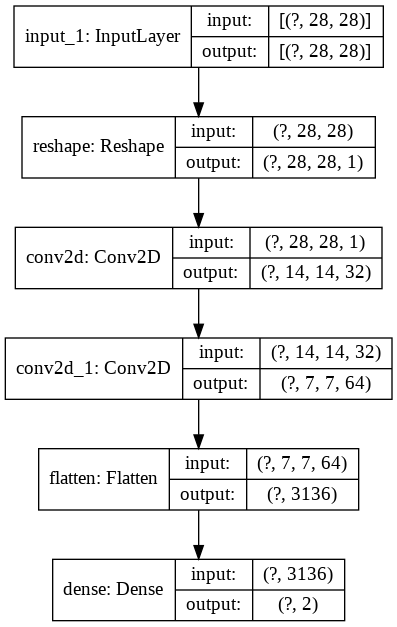

In [5]:
enc.summary()
tf.keras.utils.plot_model(enc, 'dec.png', show_shapes=True)

### 디코더 모델 정의
* Conv2DTranspose 레이어를 이용하여 인코더와 대칭적으로 이미지 확대
* n_dim 차원의 입력을 받아 Dense 레이어를 통해 3136차원으로 확대
* Reshape 레이어를 이용하여 (7x7x64)크기의 텐서로 변환한 후 64>
32>1로 채널 수를 줄여감(마지막 채널 1은 흑백을 의미)
* 출력 이미지의 시각화를 용이하게 하기 위해 인코더 입력 시 추가해주었던 흑백 채널을 Reshape(28,28)을 통해 삭제

In [0]:
dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense(3136),
  tf.keras.layers.Reshape(target_shape=(7,7,64)),
  tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='sigmoid'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),  # 흑백 채널 삭제
])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


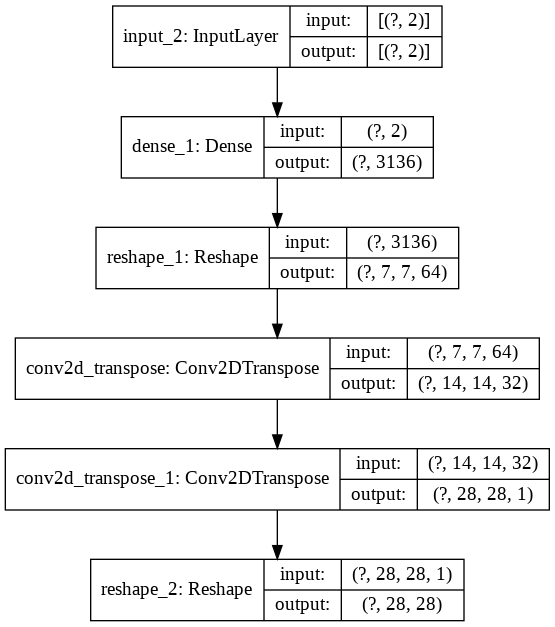

In [7]:
dec.summary()
tf.keras.utils.plot_model(dec, 'dec.png', show_shapes=True)

### 오토인코더 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [0]:
ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (28, 28) -> ae -> (28, 28)로 동작하지 않고,
    - batch 단위로 (?, 28, 28) -> ae -> (?, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [25]:
y_pred = ae(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred.shape)

input  shape: (60000, 28, 28)
output shape: (60000, 28, 28)


### train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화


In [26]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 25090     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            28161     
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


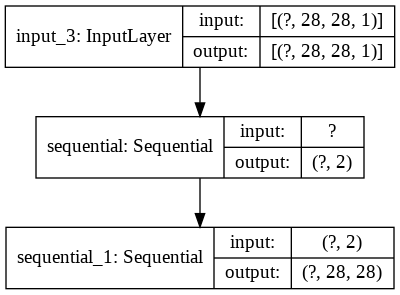

In [11]:
ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae에 대한 훈련 수행
* 인스턴스 ae를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
 
* 훈련 데이터 쌍 (train_images, train_labels)으로 fit()을 이용해 훈련 

In [27]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0581 - mae: 0.1297
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0492 - mae: 0.1133
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0471 - mae: 0.1096
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0459 - mae: 0.1073
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0450 - mae: 0.1055
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0445 - mae: 0.1043
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0440 - mae: 0.1033
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0437 - mae: 0.1025
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0434 - mae: 0.1019
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0432 - mae: 0.1014


### 트레이닝 이후 ae 함수를 다시 수행

In [0]:
y_pred = ae(train_images)

## 오토 인코더 모델 학습 결과 시각화 및 분석

* index 0, 19064, 22791 등에서 원본 이미지를 충분히 재구성하지 못함을 확인할 수 있다.

In [29]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 인코더를 거치고 나온 representation z를 시각화 하기

* 현재 z는 2차원이므로 별도의 처리 없이 pyplot을 통해 시각화할 수 있다.

In [30]:
z = enc(train_images)
print(z.shape)

(60000, 2)


* 왼쪽 그림을 보면 중심 부근에서 점들이 색깔 별로 명확히 구분되지 않고 겹쳐있음을 확인할 수 있다.
* 오른쪽 그림은 왼쪽 그림위에 인덱스 0부터 49까지의 train image를 2차원 공간에서 해당하는 점의 위에 나타낸 것인데, 실제로 (0,0) 부근에서 3과 5 등이 매우 가깝게 붙어있음을 확인할 수 있다.

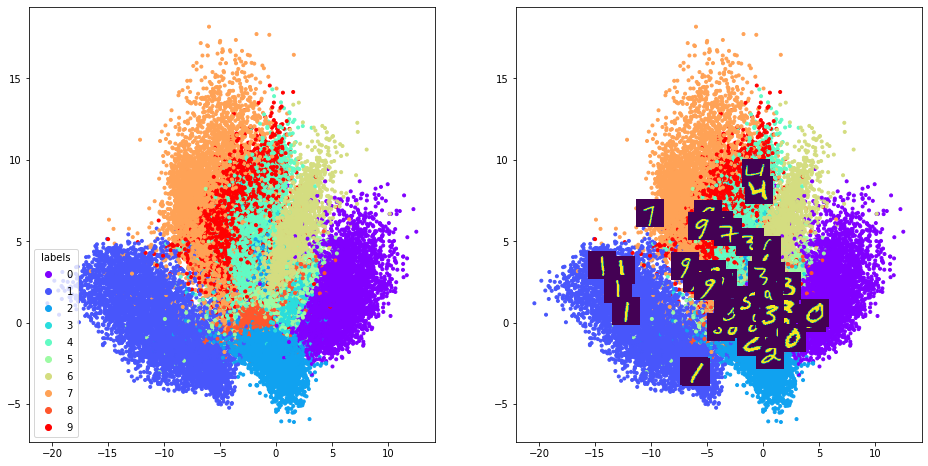

In [35]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # 산점도(scatter plot)에 train image들을 나타내기 위한 라이브러리

plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
scat = ax.scatter(z[:,0], z[:,1], marker='.', c=train_labels, cmap='rainbow')
ax.legend(*scat.legend_elements(), loc="lower left", title='labels')
bx = plt.subplot(1,2,2)
bx.scatter(z[:,0], z[:,1], marker='.', c=train_labels, cmap='rainbow')
# 0~49번 인덱스에 해당하는 train image를 산점도에서 해당하는 점 위에 표시
for i in range(50):
    imagebox = OffsetImage(train_images[i])
    ab = AnnotationBbox(imagebox, (z[i,0], z[i,1]), frameon=False, pad=0.0)
    bx.add_artist(ab)
plt.show()

# z의 차원 수 늘리기

* 위 그림에서 볼 수 있듯 인코더가 입력을 label별로 discriminative하게 나타내지 못하고 있다.
* 그 원인을 z의 차원 수가 너무 적다고 판단하여 z의 차원을 늘려보았다.


### 4차원으로 확장
* 즉, n_dim = 4
* 인코더와 디코더, 오토인코더는 위와 같은 구조를 사용

In [0]:
n_dim = 4

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape((28,28,1)),  # 채널 차원(흑백) 추가
  tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim),  
])

dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense(3136),
  tf.keras.layers.Reshape(target_shape=(7,7,64)),
  tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='sigmoid'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),  # 흑백 채널 삭제
])

ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 4)                 31364     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            34433     
Total params: 65,797
Trainable params: 65,797
Non-trainable params: 0
_________________________________________________________________


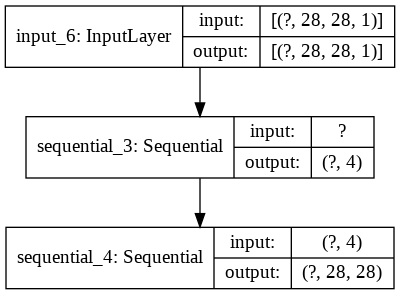

In [21]:
ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

* 차원 수만에 따른 representation의 변화를 확인하기 위해 compile의 인수들과
epochs, batch_size는 바꾸지 않고 사용하였다.

In [38]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0480 - mae: 0.1087
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0371 - mae: 0.0891
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0352 - mae: 0.0853
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0341 - mae: 0.0831
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0334 - mae: 0.0817
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0328 - mae: 0.0806
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0324 - mae: 0.0797
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0320 - mae: 0.0790
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0317 - mae: 0.0784
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0315 - mae: 0.0779


## 학습 결과 시각화 및 분석

In [0]:
y_pred = ae(train_images)

In [40]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

여전히 인덱스 0, 19064, 22791 등에서 원본 이미지를 충분히 재구성하지 못하고 있다.

## 인코더를 거친 representation z 추출

In [41]:
z = enc(train_images)
print(z.shape)

(60000, 4)


## 인코더를 거치고 나온 representation z를 시각화 하기

* 현재 z는 4차원이므로 바로 시각화 하기 어렵다.
* 따라서 t-SNE를 통해 이를 2차원으로 축소 후 시각화 하였다.

In [42]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 17min 29s, sys: 918 ms, total: 17min 29s
Wall time: 8min 56s


* z가 2차원일때와 비교해보면 1은 따로 분리가 되었고 0과 6도 약간 분리가 되었지만,

  4,7,9 등은 서로 겹쳐지는 부분이 많음을 확인할 수 있다.

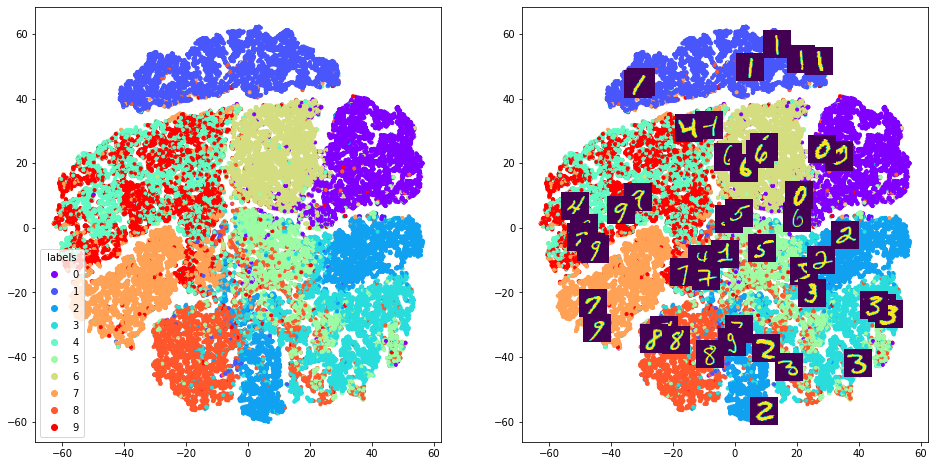

In [43]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 2차원으로 축소한 z_reduced를 scatter를 통해 산점도로 시각화
plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
scat = ax.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
ax.legend(*scat.legend_elements(), loc="lower left", title='labels')
bx = plt.subplot(1,2,2)
bx.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
# 0~49번 인덱스에 해당하는 train image를 산점도에서 해당하는 점 위에 표시
for i in range(50):
    imagebox = OffsetImage(train_images[i])
    ab = AnnotationBbox(imagebox, (z_reduced[i,0], z_reduced[i,1]), frameon=False, pad=0.0)
    bx.add_artist(ab)
plt.show()

# z의 차원 수 늘리기

* 위 그림에서 볼 수 있듯 인코더가 아직 입력을 label별로 discriminative하게 나타내지 못하고 있다.
* 따라서 z의 차원을 조금 더 늘려보았다.


### 8차원으로 확장
* 즉, n_dim = 8
* 인코더와 디코더, 오토인코더는 위와 같은 구조를 사용

In [0]:
n_dim = 8

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape((28,28,1)),  # 채널 차원(흑백) 추가
  tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim),  
])

dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense(3136),
  tf.keras.layers.Reshape(target_shape=(7,7,64)),
  tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='sigmoid'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),  # 흑백 채널 삭제
])

ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

* 차원 수만에 따른 representation의 변화를 확인하기 위해 compile의 인수들과
   epochs, batch_size는 바꾸지 않고 사용하였다.

In [46]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0351 - mae: 0.0835
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0222 - mae: 0.0588
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0208 - mae: 0.0558
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0199 - mae: 0.0540
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0193 - mae: 0.0528
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0189 - mae: 0.0520
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0186 - mae: 0.0513
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0184 - mae: 0.0507
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0181 - mae: 0.0503
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0180 - mae: 0.0499


## 학습 결과 시각화하기

In [0]:
y_pred = ae(train_images)

In [48]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

여전히 인덱스 0, 19064, 22791 등에서 원본 이미지를 충분히 재구성하지 못하고 있다.

## 인코더를 거친 representation z 추출

In [49]:
z = enc(train_images)
print(z.shape)

(60000, 8)


## 인코더를 거치고 나온 representation z를 시각화 하기

* 현재 z는 8차원이므로 바로 시각화 하기 어렵다.
* 따라서 t-SNE를 통해 이를 2차원으로 축소 후 시각화 하였다.

In [51]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 18min 33s, sys: 950 ms, total: 18min 33s
Wall time: 9min 34s


* z를 4차원으로 했을 때보다는 많이 분리되긴 했지만, 여전히 5와 8, 9와 7 등이 겹쳐져 있고 경계가 모호하다




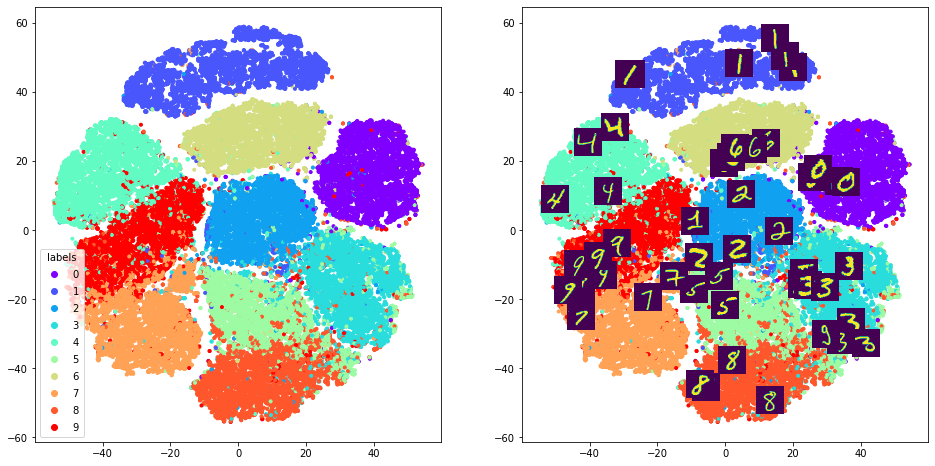

In [52]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 2차원으로 축소한 z_reduced를 scatter를 통해 산점도로 시각화
plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
scat = ax.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
ax.legend(*scat.legend_elements(), loc="lower left", title='labels')
bx = plt.subplot(1,2,2)
bx.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
# 0~49번 인덱스에 해당하는 train image를 산점도에서 해당하는 점 위에 표시
for i in range(50):
    imagebox = OffsetImage(train_images[i])
    ab = AnnotationBbox(imagebox, (z_reduced[i,0], z_reduced[i,1]), frameon=False, pad=0.0)
    bx.add_artist(ab)
plt.show()

# z의 차원 수 늘리기

* 위 그림에서 볼 수 있듯 인코더가 아직 입력을 label별로 discriminative하게 나타내지 못하고 있다.
* 따라서 z의 차원을 조금 더 늘려보았다.


### 16차원으로 확장
* 즉, n_dim = 16
* 인코더와 디코더, 오토인코더는 위와 같은 구조를 사용

In [0]:
n_dim = 16

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape((28,28,1)),  # 채널 차원(흑백) 추가
  tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim),  
])

dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense(3136),
  tf.keras.layers.Reshape(target_shape=(7,7,64)),
  tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='sigmoid'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),  # 흑백 채널 삭제
])

ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

* 차원 수만에 따른 representation의 변화를 확인하기 위해 compile의 인수들과 epochs, batch_size는 바꾸지 않고 사용하였다.

In [59]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0259 - mae: 0.0647
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0115 - mae: 0.0368
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0102 - mae: 0.0340
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0096 - mae: 0.0326
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0092 - mae: 0.0318
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - mae: 0.0312
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - mae: 0.0308
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0086 - mae: 0.0304
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0084 - mae: 0.0301
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0083 - mae: 0.0299


## 학습 결과 시각화하기

In [0]:
y_pred = ae(train_images)

In [61]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

지금까지 인덱스 0, 19064, 22791 등에서 재구성에 어려움이 있었는데, z의 차원을 16으로 늘리니 재구성이 잘 되었음을 확인할 수 있다.

## 인코더를 거친 representation z 추출

In [62]:
z = enc(train_images)
print(z.shape)

(60000, 16)


## 인코더를 거치고 나온 representation z를 시각화 하기

* 현재 z는 16차원이므로 바로 시각화 하기 어렵다.
* 따라서 t-SNE를 통해 이를 2차원으로 축소 후 시각화 하였다.

In [63]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 21min, sys: 1.16 s, total: 21min 1s
Wall time: 11min 13s


* 아래 산점도를 보면 z가 8차원일 때보다 각 label 들이 잘 분리되었음을 볼 수 있다.

  그러나 5, 8, 3 등의 경계가 서로 붙어있고, 7이 모여있는 부분에서 약간의 틈이 보인다.

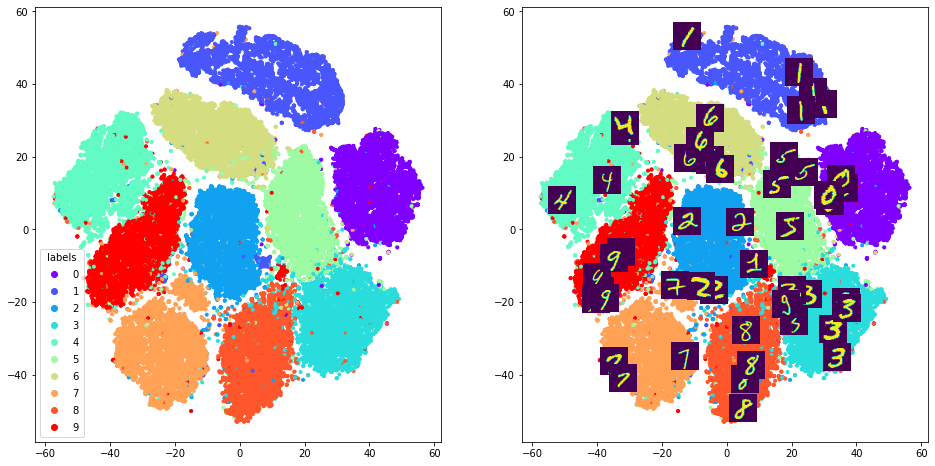

In [64]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 2차원으로 축소한 z_reduced를 scatter를 통해 산점도로 시각화
plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
scat = ax.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
ax.legend(*scat.legend_elements(), loc="lower left", title='labels')
bx = plt.subplot(1,2,2)
bx.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow'
# 0~49번 인덱스에 해당하는 train image를 산점도에서 해당하는 점 위에 표시
for i in range(50):
    imagebox = OffsetImage(train_images[i])
    ab = AnnotationBbox(imagebox, (z_reduced[i,0], z_reduced[i,1]), frameon=False, pad=0.0)
    bx.add_artist(ab)
plt.show()

# Dense 레이어 추가하기

* z를 16차원으로 늘리니 인코더가  입력을 상당 부분 discriminative 하게 represent함을 확인할 수 있었다.
* 그러나 위에서 언급했듯 각 label간의 경계나, label 내에서 틈이 보이는 문제를 조금 더 개선할 수 있으면 좋을 것 같다고 생각했다.
* 위와 같은 현상을 개선하기 위해 z의 차원을 더 크게 해볼수도 있었지만, Flatten() 후 3136차원을 바로 16차원으로 축소하는 것이 너무 급격하다는 생각이 들었다.
* 따라서, z의 차원(n_dim)을 크게하지 않고 Flatten() 레이어 후 Dense 레이어를 추가하여 3136>1024>16 의 순서로 차원으로 줄여보았다.

In [0]:
n_dim = 16

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape((28,28,1)),  # 채널 차원(흑백) 추가
  tf.keras.layers.Conv2D(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024), # 1024개의 unit을 가지는 Dense 레이어 추가
  tf.keras.layers.Dense(n_dim),  
])

dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense(1024), # 1024개의 unit을 가지는 Dense 레이어 추가
  tf.keras.layers.Dense(3136),
  tf.keras.layers.Reshape(target_shape=(7,7,64)),
  tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
  tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='sigmoid'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),
])

ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

* Dense 레이어 추가만에 따른 representation의 변화를 확인하기 위해 epochs, batch_size는 바꾸지 않고 사용하였다.

In [67]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0193 - mae: 0.0520
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0106 - mae: 0.0349
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0098 - mae: 0.0333
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - mae: 0.0322
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - mae: 0.0314
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - mae: 0.0308
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0086 - mae: 0.0304
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0084 - mae: 0.0301
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0083 - mae: 0.0298
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0082 - mae: 0.0296


## 학습 결과 시각화하기

In [0]:
y_pred = ae(train_images)

In [69]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

Dense(1024) 레이어를 추가하고도 0, 19064, 22791 등에서 재구성이 잘 되었음을 확인할 수 있다.

## 인코더를 거친 representation z 추출

In [70]:
z = enc([train_images, train_labels])
print(z.shape)

(60000, 16)


## 인코더를 거치고 나온 representation z를 시각화 하기

* 현재 z는 16차원이므로 바로 시각화 하기 어렵다.
* 따라서 t-SNE를 통해 이를 2차원으로 축소 후 시각화 하였다.

In [71]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 20min 33s, sys: 1.18 s, total: 20min 34s
Wall time: 11min 1s


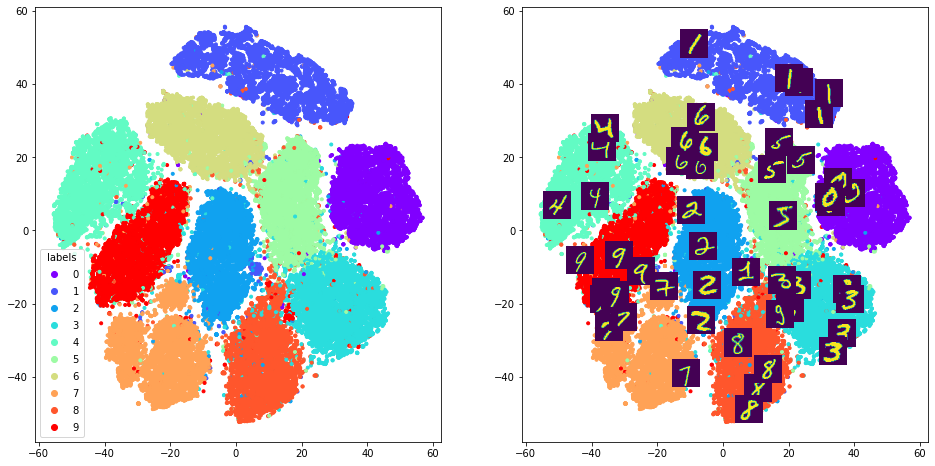

In [72]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 2차원으로 축소한 z_reduced를 scatter를 통해 산점도로 시각화
plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
scat = ax.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
ax.legend(*scat.legend_elements(), loc="lower left", title='labels')
bx = plt.subplot(1,2,2)
bx.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
# 0~49번 인덱스에 해당하는 train image를 산점도에서 해당하는 점 위에 표시
for i in range(50):
    imagebox = OffsetImage(train_images[i])
    ab = AnnotationBbox(imagebox, (z_reduced[i,0], z_reduced[i,1]), frameon=False, pad=0.0)
    bx.add_artist(ab)
plt.show()

위 산점도를 보면 미세하지만 5, 8, 3 사이에 하얀 틈이 보이며 경계를 확인할 수 있었다.

7의 집합은 여전히 틈이 있긴 하지만 오른쪽 산점도에 표시한 이미지를 보면
평범한 7과 가운데에 -이 그어진 7로 분리되어 있음을 확인할 수 있는데,

평범한 7의 모양을 생각해보았을 때 -이 그어진 것은 꽤 큰 특징이라고 볼 수 있고, 이 정도의 틈은 존재할만하다고 생각한다.


---


추가적으로 몇개의 데이터들이 다른 label들의 집합에 찍혀있음을 확인할 수 있다. (군데 군데 떨어져 있는 색상의 점들)

이에 대해 고민하던 중, TSNE 논문에서 아래와 같은 내용을 찾을 수 있었다.
* 출처 : [TSNE 논문 일부(pdf), 10-12 페이지 내용](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

>> TSNE의 성능을 평가하기 위해 MNIST 데이터 셋에서 랜덤하게 6,000개의 샘플을 추출했고, PCA로 784차원을 30차원으로 축소한 후 TSNE를 적용하였다.

아래는 그 결과를 시각화 한 그림이다.



![대체 텍스트](https://lovit.github.io/assets/figures/tsne_mnist.png)


그림에서 보이는 것 처럼 TSNE의 개발자들이 행한 실험에서도 outlier들은 상당수 존재하였다.

이는 TSNE를 포함한 차원 축소 알고리즘이 일부 정보를 유실할 수 밖에 없는 구조적 이유이기 때문이기도 하지만, 

실습을 하면서 MNIST 데이터의 원초적인 문제도 있다고 생각한다.

아래 이미지들이 보여주듯 MNIST 데이터셋의 일부 데이터가 사람이 보기에도 애매하게 쓰여졌거나 다른 사람들과 다르게 특징있는 필체로 쓰여졌다.

이 때문에 outlier들이 존재한다고 판단하였고, 현재의 조건이 최적에 가깝다고 판단하였다.



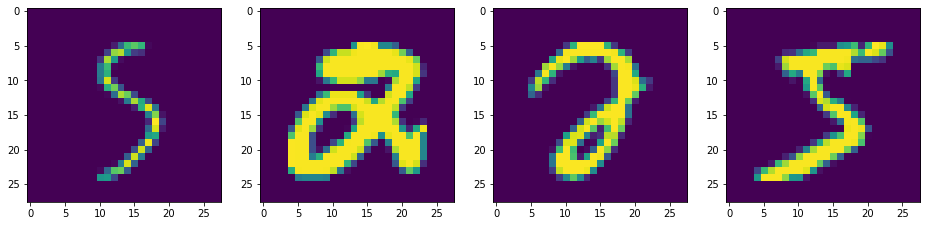

In [73]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(train_images[36774])
plt.subplot(1,4,2)
plt.imshow(train_images[36475])
plt.subplot(1,4,3)
plt.imshow(train_images[56612])
plt.subplot(1,4,4)
plt.imshow(train_images[0])
plt.show()

## 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
다음과 같은 방법으로 트레이닝이 끝난 오토인코더의 enc와 dec를 각각 수행할 수 있다.

In [0]:
z = enc(train_images)
y_pred = dec(z)

## 인코딩 결과 확인 및 디코딩 결과 확인
* 특정 이미지에 대한 인코딩 결과를 확인한다.
* 아래의 z는 차원 수가 16이고 Flatten() 이후 1024개의 unit을 가지는 Dense 레이어를 추가한 인코더를 거쳐 나온 representation이다.


In [75]:
import ipywidgets as widgets

def z_show(idx):
  print('GT label:', train_labels[idx])
  print(z[idx].numpy())
  
widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.




In [79]:
import ipywidgets as widgets

a=widgets.FloatSlider(min=-10.0, max=10.0)
b=widgets.FloatSlider(min=-10.0, max=10.0)
c=widgets.FloatSlider(min=-10.0, max=10.0)
d=widgets.FloatSlider(min=-10.0, max=10.0)
e=widgets.FloatSlider(min=-10.0, max=10.0)
f=widgets.FloatSlider(min=-10.0, max=10.0)
g=widgets.FloatSlider(min=-10.0, max=10.0)
h=widgets.FloatSlider(min=-10.0, max=10.0)
i=widgets.FloatSlider(min=-10.0, max=10.0)
j=widgets.FloatSlider(min=-10.0, max=10.0)
k=widgets.FloatSlider(min=-10.0, max=10.0)
l=widgets.FloatSlider(min=-10.0, max=10.0)
m=widgets.FloatSlider(min=-10.0, max=10.0)
n=widgets.FloatSlider(min=-10.0, max=10.0)
o=widgets.FloatSlider(min=-10.0, max=10.0)
p=widgets.FloatSlider(min=-10.0, max=10.0)


ui = widgets.HBox([a,b,c,d])
uii = widgets.HBox([e,f,g,h])
uiii = widgets.HBox([i,j,k,l])
uiiii = widgets.HBox([m,n,o,p])

def z_test(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p):
  z_test = np.array([[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p]])  
  print(z_test)

  img_gen = dec(z_test)
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'f': f, 'g': g, 'h': h,
                                             'i': i, 'j': j, 'k': k, 'l': l, 'm': m, 'n': n, 'o': o, 'p': p})

display(ui, uii, uiii, uiiii, out)

Output()

앞 셀에서 확인한 [-0.71460295 ..... 0.15520345]를 입력시 '8'를 나타내는 이미지를 구성해야 한다. (index : 59999)

실제로 FloatSlider를 이용하여 값을 주면 오른쪽으로 약간 기울어진 8로 보이는 이미지를 구성한다.

또한, [-0.71460295 ..... 0.15520345]를 기준으로 각 차원의 값을 조금씩 조절하더라도 8로 인식할 수 있는 이미지를 구성함을 확인할 수 있다.


---


각각의 FloatSlider를 하나씩 조절해보면 각 차원이 입력 이미지의 어느 특징을 represent했는지 알 수 있다.

16차원의 좌표를 입력으로 주기 위해 알파벳 a부터 p까지 총 16개의 FloatSlider를 만들었다.


---



예를 들어 첫 번째 슬라이더를 왼쪽으로 움직일수록 8을 구성하는 위아래 두 개의 원이 넓어지고,

오른쪽으로 움직일수록 점점 좁아져 끝으로 가면 붙어버리는 것을 볼 수 있다.

숫자 마다 다르겠지만, 8의 경우 z의 첫번째 차원은 8의 너비와 관련된 특징을 학습했음을 유추할 수 있다.

추가적으로 6번째 슬라이더를 좌우로 움직여보면 왼쪽으로 움직일수록 선의 두께가 두꺼워지고,

오른쪽으로 움직이면 선의 두께가 얇아지는 것을 볼 수 있다.

이를 통해 z의 6번째 차원은 숫자를 쓰는 선의 두께와 관련된 특징을 학습했다고 유추할 수 있다.


## 디코더를 이용한 Generative Model 구성

위에서 활용한 FloatSlider를 통해서 디코더에 주입할 입력을 쉽게 생성할 수 있다.


그러나 아래에서 확인할 수 있듯 representaion z의 각 차원은 대부분 8~10의 범위를 가지고,

FloatSlider를 0.1 단위로 조절하는 것을 생각하면 각 차원마다 80~100의 경우의 수를 가진다.

전체가 16차원이기 때문에 적어도 80^16 가지의 조합이 가능한데, 숫자가 그려지는 차원은 상대적으로 매우 작기 때문에

임의로 16차원의 데이터를 생성해서 숫자 이미지를 얻기는 매우 어렵다고 판단했다.


따라서, z를 같은 GT(label)별로 평균을 낸 후 그 값을 참고하여 디코더에 입력을 넣고 결과를 비교하였다.



In [77]:
for i in range(z.shape[1]):
  ran = z[:][i].numpy().max() - z[:][i].numpy().min()
  print('range of dimension', i+1, ':', ran)

range of dimension 1 : 8.259018
range of dimension 2 : 7.848352
range of dimension 3 : 8.90218
range of dimension 4 : 8.075583
range of dimension 5 : 7.494337
range of dimension 6 : 6.8320465
range of dimension 7 : 10.319784
range of dimension 8 : 6.0404243
range of dimension 9 : 9.867009
range of dimension 10 : 9.401773
range of dimension 11 : 3.839626
range of dimension 12 : 9.477467
range of dimension 13 : 6.8273067
range of dimension 14 : 6.602083
range of dimension 15 : 11.321423
range of dimension 16 : 10.648963


In [0]:
# 레이블(0~9)을 입력으로 받고 해당 레이블을 가지는 이미지의 인덱스들을 반환하는 함수
def find_label (label, x):
    r = np.arange(len(label))
    mask = (label == x)
    idx = r[mask]
    return idx

# z와 인덱스 배열을 입력으로 받고 z에서 해당하는 인덱스 열들의 평균을 반환하는 함수 
def find_mean(z, idx):
    mean_label = np.mean(tf.gather(z, idx), axis=0)
    return mean_label

In [197]:
# 각 label에 대한 평균을 구하여 출력
mean_digits = np.zeros((10,16))
for i in range(10):
  digit = find_label(train_labels, i)
  mean_digits[i][:] = find_mean(z, digit)
  print('label', i, '\'s mean :', mean_digits[i])
  print()

label 0 's mean : [ 1.41602027  2.30989504  4.53366423 -0.41714111 -1.31858897  1.75616467
  0.35301787 -1.88541114 -1.71287215 -2.22441244  0.41088176 -0.34400019
  1.20624912 -0.05068878 -0.33778521  0.28081936]

label 1 's mean : [-0.79812092 -0.34634987 -3.78121781 -2.11754704  1.42026055 -0.68019342
 -3.82797956  0.7078436  -0.76920199  2.39321375 -1.21107709  0.3024008
 -2.18473887  2.02590656 -1.85866761 -1.0649358 ]

label 2 's mean : [ 0.45607874 -0.19999321 -1.91490757  0.04240766  0.16729164  1.86877429
 -1.37786591 -0.27394742 -1.55988729 -0.31762376  2.80586171  0.95470148
  1.71397746 -0.16462988 -0.65154403 -1.03163242]

label 3 's mean : [-2.37552166 -1.56588936 -0.47094655  0.05340782  0.03181003  1.45377421
  0.14274542 -0.35994798 -1.61751533 -0.0673773  -1.63834774 -0.65191144
  2.37256765 -0.694888   -1.05736434 -0.26216376]

label 4 's mean : [-0.68420941  1.67061281 -0.59374994 -1.28769648 -0.24103589 -0.01848012
 -0.36280686  0.89631689  2.00926328 -2.95847154 -

In [0]:
# 정규분포를 따르는 난수 16차원의 데이터 3개 생성
random_numbers = np.zeros((3, 16))
for i in range(3):
  random_numbers[i] = np.random.randn(16)

# 0, 6, 7 레이블의 평균 값에서 일부 조절하여 데이터 생성
zero_like = mean_digits[0] +1
six_like = mean_digits[6] *1.5
seven_like = mean_digits[7] -1

zero_like_2 = mean_digits[0] +2
six_like_2 = mean_digits[6] *0.5
seven_like_2 = mean_digits[7] -2

zero_like_3 = mean_digits[0] +3
six_like_3 = mean_digits[6] *0.25
seven_like_3 = mean_digits[7] -3

In [215]:
# 위에서 생성한 데이터를 하나의 배열로 합침
z = np.zeros((12,16))
for i in range(3):
  z[i] = (random_numbers[i])

z[3] = zero_like
z[4] = six_like
z[5] = seven_like
z[6] = zero_like_2
z[7] = six_like_2
z[8] = seven_like_2
z[9] = zero_like_3
z[10] = six_like_3
z[11] = seven_like_3

# 임의로 생성한 데이터를 디코더에 통과시켜 이미지를 얻음
result = dec(z)

print(z.shape)
print(result.shape)

(12, 16)
(12, 28, 28)


* 임의 생성 데이터로부터 얻은 이미지 가시화

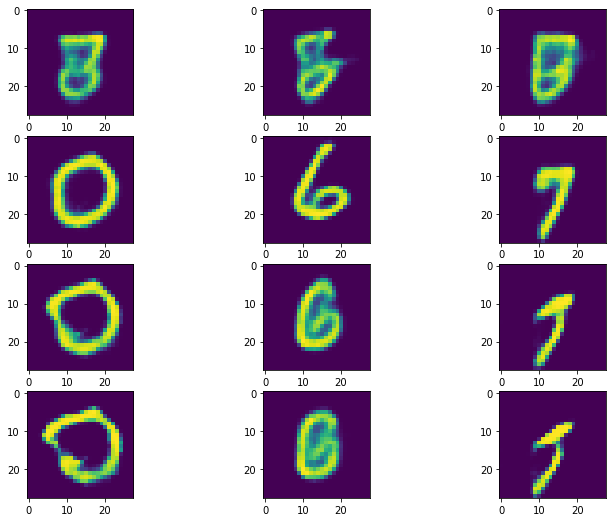

In [216]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.imshow(result[i])

위의 3 by 4 이미지들의 첫 번째 열은 넘파이의 randn을 이용하여 정규분포에서 추출한 난수를 디코딩한 결과이다.

첫 번째 열의 이미지들을 보면 보는 사람에 따라 숫자라고 생각하지 않거나, 0~9의 숫자 중 8과 제일 유사하다고 볼 수 있다.

첫 번째 열의 이미지들이 그나마 숫자 8과 유사한 이유는 위에서 구한 숫자 이미지들이 인코딩된 평균을 보면 이해할 수 있다.

다른 숫자들에 비해 숫자 8이 인코딩된 평균은 각 차원의 값이 0에 가깝게 분포되어 있기 때문에 정규분포를 따라 추출한 난수들이 디코딩 된 결과는 8에 가장 가까운 모양을 보인다.

아래의 세 열은 각각 0, 2, 3의 평균에서 +, *, - 를 하여 디코딩한 결과인데, 아래로 갈수록 그 정도를 크게 하였다.

실제로 이미지를 보면 2열에서 가장 0, 2, 3과 가까운 모양이고, 4열에서 가장 변형된 모습을 확인할 수 있다.

앞서 TSNE를 통해 얻은 2차원 산점도를 보면 각 label별로 타원 같은 모양을 이루고 있음을 볼 수 있는데, 

각 label들로 평균을 내면 타원의 중심 부근에 찍힐 것이므로 정확도 높은 숫자 이미지를 얻을 것이라 기대할 수 있다.

각 label들의 평균에 숫자를 더하거나 뺀다면 타원의 중심에서 점점 멀어지며 다른 숫자로 변하거나 숫자처럼 보이지 않는 이미지를 생성할 것이다.




---


과제 제출을 위해 일부 샘플을 직접 배열로 만들어서 위와 같은 작업을 했지만

위처럼 직접 16차원의 좌표를 가지는 배열을 만들어서 디코더에 넣는 작업은 시간도 오래 걸리고,

조금씩 변화시켜가며 확인하기가 쉽지 않아 주로 FloatSlider를 이용하여 임의의 샘플을 만들고 디코딩 해보았습니다.

슬라이더들을(코드 셀들) 여러 개 만들어 각기 다른 샘플들을 생성한 것을 보여드릴 수 있지만

너무 길어지고 단순 작업이라 생각하여 그렇게 하지 않은 점 이해해주시면 감사하겠습니다.


---
아래 이미지는 숫자 6의 평균인 다음 값에서 조금씩 변화시켜 본 결과입니다.


[ 1.03947711 3.31209087 -1.32396197 0.82056159 0.8427788 0.53472149 -0.56595272 -2.05247855 0.76948148 -0.37531921 -0.83647752 -2.50328469 0.02001575 0.91891676 -0.37097427 -0.89167964]


In [181]:
import ipywidgets as widgets

a=widgets.FloatSlider(min=-10.0, max=10.0)
b=widgets.FloatSlider(min=-10.0, max=10.0)
c=widgets.FloatSlider(min=-10.0, max=10.0)
d=widgets.FloatSlider(min=-10.0, max=10.0)
e=widgets.FloatSlider(min=-10.0, max=10.0)
f=widgets.FloatSlider(min=-10.0, max=10.0)
g=widgets.FloatSlider(min=-10.0, max=10.0)
h=widgets.FloatSlider(min=-10.0, max=10.0)
i=widgets.FloatSlider(min=-10.0, max=10.0)
j=widgets.FloatSlider(min=-10.0, max=10.0)
k=widgets.FloatSlider(min=-10.0, max=10.0)
l=widgets.FloatSlider(min=-10.0, max=10.0)
m=widgets.FloatSlider(min=-10.0, max=10.0)
n=widgets.FloatSlider(min=-10.0, max=10.0)
o=widgets.FloatSlider(min=-10.0, max=10.0)
p=widgets.FloatSlider(min=-10.0, max=10.0)


ui = widgets.HBox([a,b,c,d])
uii = widgets.HBox([e,f,g,h])
uiii = widgets.HBox([i,j,k,l])
uiiii = widgets.HBox([m,n,o,p])

def z_test(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p):
  z_test = np.array([[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p]])  
  print(z_test)

  img_gen = dec(z_test)
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'f': f, 'g': g, 'h': h,
                                             'i': i, 'j': j, 'k': k, 'l': l, 'm': m, 'n': n, 'o': o, 'p': p})

display(ui, uii, uiii, uiiii, out)

Output()